# Fine Tuning Albert Transformer
* Notebook by Adam Lang
* Date: 9/30/2024

# Overview
* In this notebook we will fine-tune an Albert Transformer from huggingface or classification tasks.
* We will use the model through the huggingface inference API.

# Model Info
* `albert-base-v2` model was fine-tuned for sequence classification sentiment analysis using TextAttack and the imdb dataset loaded using the nlp library.
* model card: https://huggingface.co/textattack/albert-base-v2-imdb

# Dataset
* kaggle games review dataset from 2024

# Fine-Tuning Task
* Fine-tune model for binary sequence classification (0 or 1) on kaggle video games dataset.
* Task: unfreeze classification layer, freeze all other layers.

## Imports

In [1]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader

## BertTokenizer, BertForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## DS imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Upload Data

In [2]:
## 3 datasets
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/train.csv')
df_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/validation.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/test.csv')

In [3]:
## df_train head
df_train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"Early Access ReviewVery great shooter, that ha...",1
1,2166,Tree of Savior (English Ver.),2016.0,I love love love playing this game!Super 100%!...,1
2,17242,Eternal Card Game,2016.0,Early Access ReviewAs a fan of MTG and Hearths...,1
3,6959,Tactical Monsters Rumble Arena,2018.0,Turn based strategy game similiar to FF Tactic...,1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,This game has an insanely huge download for be...,0


## Quick EDA on df_train

In [4]:
## eda
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17877 entries, 0 to 17876
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17877 non-null  int64  
 1   title            17877 non-null  object 
 2   year             17698 non-null  float64
 3   user_review      17877 non-null  object 
 4   user_suggestion  17877 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 698.4+ KB


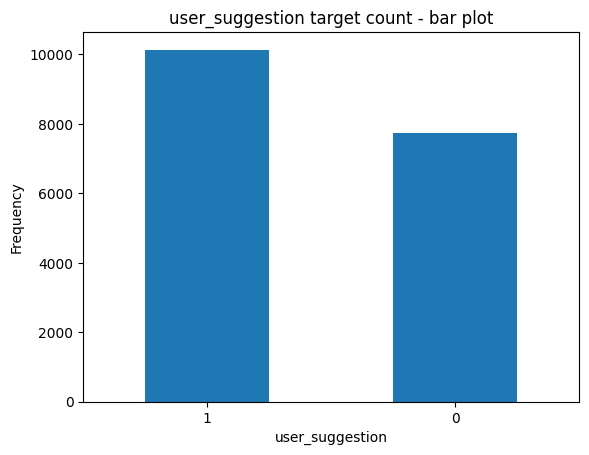

In [5]:
## user_suggestion
df_train['user_suggestion'].value_counts().plot(kind='bar')
plt.title('user_suggestion target count - bar plot')
plt.xlabel('user_suggestion')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show();

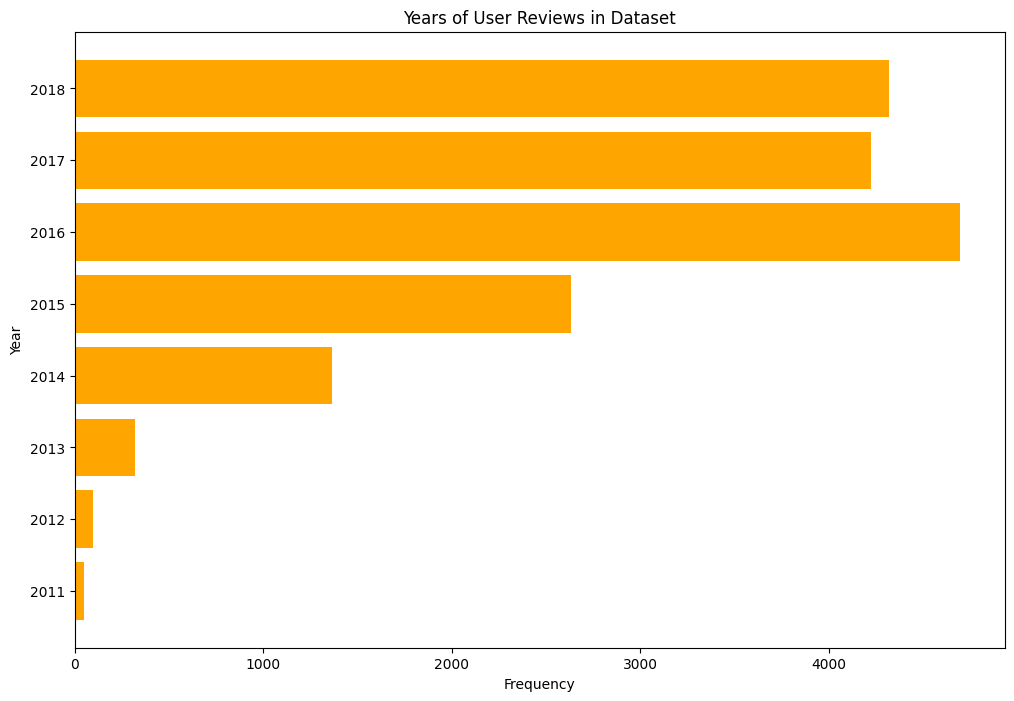

In [6]:
## quick plot of years
## get current axes of plot
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12,8))
ax = plt.gca()
## plot
counts = df_train['year'].value_counts().sort_values(ascending=False)
ax.barh(counts.index, counts.values, color='orange')

plt.title('Years of User Reviews in Dataset')
plt.xlabel('Frequency')
plt.ylabel('Year')
# Force integer y-axis labels
ax.set_yticks(counts.index) # Set y-tick locations to unique years
ax.set_yticklabels(counts.index.astype(int)) # Set y-tick labels to integer years

plt.show();

Summary:
* Looks like 2016 had the most reviews and 2011 had the least

## Load Albert Model from huggingface

In [7]:
## load model
model_name = 'textattack/albert-base-v2-imdb'

## load tokenizer
tokenizer = AlbertTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)

## Classification model instantiation
model = AlbertForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

## Custom Dataset Class - PyTorch
* Let's define a custom dataset class using PyTorch
* This is useful when fine-tuning a model.

In [8]:
## CustomDataset
## processes text -- attention masks, input_ids --> pairs with labels
## this will also support batching during model training
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts.iloc[idx])
    label = self.labels.iloc[idx]

    ## encode text
    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }

### Setting Max Sequence Length
* Here we set MAX_LEN to 128.
* BERT models max_sequence_length is usually 512.
  * By setting this max_len at 128 we will be sure NOT to reach the threshold input max_len of 512 and also manage our resources during fine-tuning effectively.

In [9]:
## set max sequence length
MAX_LEN = 128

### Initialize Custom Datasets
* Each takes in:
  * X
  * y
  * tokenizer
  * MAX_LEN

In [10]:
## create torch DataLoaders for train and val sets: x, y, tokenizer, MAX_LEN
train_dataset = CustomDataset(df_train['user_review'], df_train['user_suggestion'], tokenizer, MAX_LEN)
val_dataset = CustomDataset(df_validation['user_review'], df_validation['user_suggestion'], tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test['user_review'], df_test['user_suggestion'], tokenizer, MAX_LEN)


### Initialize Custom DataLoaders

In [11]:
## init batch_size
batch_size = 32

## dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) ##don't shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) ## dont shuffle test set


### Setup Training Parameters

In [12]:
## params for training
batch_size = 32
epochs = 30
lr = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
## Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## send model to device
model = model.to(device)

In [14]:
## check device
device

device(type='cuda')

### Freeze All layers except Classification Layer


In [15]:
## freeze all layers -- we want to fine-tune a classifier
for param in model.parameters():
  param.requires_grad = False ## freeze layer

## unfreeze classification layer
for param in model.classifier.parameters():
  param.requires_grad = True ## unfreeze layer

### Calculate Accuracy function

In [17]:
## calculate accuracy
def calculate_accuracy(model, loader, device):
  model.eval()
  ## init correct var
  correct, total = 0, 0
  with torch.no_grad():
    for batch in loader:
      input_ids = batch['input_ids'].to(device) ## to device
      attention_mask = batch['attention_mask'].to(device) ## to device
      labels = batch['label'].to(device) ## to device

      outputs = model(input_ids, attention_mask=attention_mask)
      preds = torch.argmax(outputs.logits, dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  return 100 * correct / total

### Training Loop

In [19]:
## val_loss
best_val_loss = float('inf') ## init best_val_loss to very high value
## best_epoch
best_epoch = -1 #init best_epoch to an invalid value to track epoch of best val loss

## Training loop
for epoch in range(epochs):
  #1. Forward pass
  model.train()

  #2. calculate the loss
  total_train_loss = 0
  total_val_loss = 0

  # batch train
  for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    #3. optimizer zero grad -- zero out gradients
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss

    #4. loss backward - backpropagation
    loss.backward()

    #5. optimizer step -- apply updated weights
    optimizer.step()

    ## total_train_loss
    total_train_loss += loss.item()

  avg_train_loss = total_train_loss / len(train_loader)


  ## Testing Loop - validation
  model.eval()
  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
    ## 1. Forward pass
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    ## 2. Calc test loss/accuracy
      loss = outputs.loss
      total_val_loss += loss.item()

  avg_val_loss = total_val_loss / len(val_loader)

  # check if current validation loss is lowest -- if so save model!
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    best_epoch = epoch
    ## save best model
    torch.save(model.state_dict(), 'best_model.pth')

## print out whats happening - every 10th epoch
  #if epoch % 10 == 0:
  print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

#Print best epoch and its validation loss
print(f"The lowest validation loss was {best_val_loss:.4f} at epoch {best_epoch + 1}")

# Load best model and calc accuracy
model.load_state_dict(torch.load('best_model.pth'))
train_accuracy = calculate_accuracy(model, train_loader, device)
val_accuracy = calculate_accuracy(model, val_loader, device)

print(f"Best Model Train Accuracy: {train_accuracy:.2f}%")
print(f"Best Model Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/30 | Training Loss: 0.3556 | Validation Loss: 0.3501
Epoch 2/30 | Training Loss: 0.3560 | Validation Loss: 0.3497
Epoch 3/30 | Training Loss: 0.3543 | Validation Loss: 0.3500
Epoch 4/30 | Training Loss: 0.3541 | Validation Loss: 0.3493
Epoch 5/30 | Training Loss: 0.3545 | Validation Loss: 0.3491
Epoch 6/30 | Training Loss: 0.3545 | Validation Loss: 0.3488
Epoch 7/30 | Training Loss: 0.3538 | Validation Loss: 0.3485
Epoch 8/30 | Training Loss: 0.3539 | Validation Loss: 0.3481
Epoch 9/30 | Training Loss: 0.3528 | Validation Loss: 0.3479
Epoch 10/30 | Training Loss: 0.3533 | Validation Loss: 0.3485
Epoch 11/30 | Training Loss: 0.3532 | Validation Loss: 0.3475
Epoch 12/30 | Training Loss: 0.3523 | Validation Loss: 0.3476
Epoch 13/30 | Training Loss: 0.3529 | Validation Loss: 0.3469
Epoch 14/30 | Training Loss: 0.3517 | Validation Loss: 0.3470
Epoch 15/30 | Training Loss: 0.3509 | Validation Loss: 0.3464
Epoch 16/30 | Training Loss: 0.3529 | Validation Loss: 0.3464
Epoch 17/30 | Tra

<ipython-input-19-bd56583d8c00>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Best Model Train Accuracy: 85.17%
Best Model Val Accuracy: 84.39%


In [21]:
## final model on test_accuracy
best_model_path = '/content/best_model.pth'
model.load_state_dict(torch.load(best_model_path))
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy}%")

<ipython-input-21-982d58872ce9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 85.46071521795876%


# Summary
* We were able to fine-tune an Albert model with decent accuracy:
  * Train_accuracy: 85.17%
  * Val_accuracy: 84.39%
  * Test_accuracy: 85.46%
* The test accuracy is actually better than the train accuracy and there isn't too much of a gap so the model did quite well on unseen data.